In [1]:
import os
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
from collections import defaultdict
import collections
import scipy.stats as st

import networkx as nx
import gmatch4py as gm

import sys
sys.path.append("..\\Git\\complex_stylized_supply_chain_model_generator")

from complex_toy_model_graph_generator import ComplexSimModelGraph
from structure_model_composer.set_locations_of_structures import plot_graph_locations_with_pos

<frozen importlib._bootstrap>:228: UserWarning: To obtain optimal results install the Cython 'munkres' module at  https://github.com/jfrelinger/cython-munkres-wrapper


In [19]:
data={}
x={}
y={}

In [21]:
#upload all percentages
technique = "abc"
sparseness = "bias"
directory = f"./{technique}_{sparseness}"
#Over folders
for folder in os.listdir(directory):
    if not folder.startswith('.'):
        new_dir = directory+"/"+folder
        if os.path.isdir(new_dir):
            for filename in os.listdir(new_dir):
                if filename.endswith(".pkl"):
                    f = new_dir+"/"+filename

                    key = filename.split('_')[:2]
                    key = "_".join(key)

                    with open(f, "rb") as file:
                         info = pickle.load(file)
                        
                    seed = info["Model_info"]["parameters"]["seed"]
                    
                    try:
                        data[seed][key] = info
                    except KeyError:
                        data[seed] = {key: info}
for k, v in data.items():
    data[k] = dict(sorted(data[k].items(), key=lambda item: int(item[0].split('_')[1])))

In [22]:
# Check if complete
for k, v in data.items():
    print(k, data[k].keys())

1 dict_keys(['abc_0', 'abc_10', 'abc_20', 'abc_30', 'abc_40', 'abc_50', 'abc_60', 'abc_70', 'abc_80', 'abc_90'])
6 dict_keys(['abc_0', 'abc_10', 'abc_20', 'abc_30', 'abc_40', 'abc_50', 'abc_60', 'abc_70', 'abc_80', 'abc_90'])
11 dict_keys(['abc_0', 'abc_10', 'abc_20', 'abc_30', 'abc_40', 'abc_50', 'abc_60', 'abc_70', 'abc_80', 'abc_90'])
16 dict_keys(['abc_0', 'abc_10', 'abc_20', 'abc_30', 'abc_40', 'abc_50', 'abc_60', 'abc_70', 'abc_80', 'abc_90'])
21 dict_keys(['abc_0', 'abc_10', 'abc_20', 'abc_30', 'abc_40', 'abc_50', 'abc_60', 'abc_70', 'abc_80', 'abc_90'])
26 dict_keys(['abc_0', 'abc_10', 'abc_20', 'abc_30', 'abc_40', 'abc_50', 'abc_60', 'abc_70', 'abc_80', 'abc_90'])


# Calculate Quality of Fit

In [6]:
#Basic parameters
with open(r"../../complex_stylized_supply_chain_model_generator/data/location_model_hpc_40000_cnhk_usa_airsea.pkl", "rb") as f:
    decision_variables = pickle.load(f)

with open(r"../../complex_stylized_supply_chain_model_generator/data/Ground_Truth_Graph_Topology_DF_CNHK_USA.pkl", "rb") as f:
    ground_truth_topology = pickle.load(f)

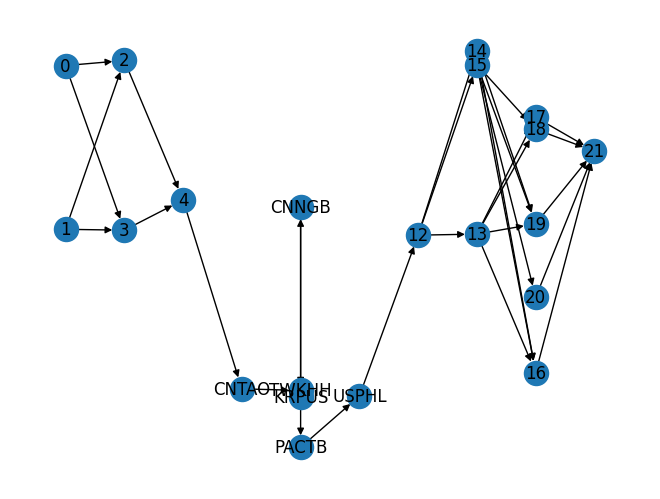

In [31]:
plot_graph_locations_with_pos(decision_variables[39999]["graph"])

## Remove burnin period

In [23]:
res_abc = {}
#remove burnin
for k, v in data.items():
    for perc, r in v.items():
        dict_res = data[k][perc]["Results"]["graph_structure"]
        n_following = 0
        keys_following = []
        
        dict_results_per_no_burnin = dict_res.copy()
        list_keys = list(dict_results_per_no_burnin.keys())
    
        next_key = 0
        for key, value in dict_res.items():
            if round(value, 0) == round(dict_res[next_key], 0):
                n_following += 1
                keys_following.append(key)
                try:
                    if key == "0":
                        next_key = "0"
                    else:
                        next_key = list_keys[list_keys.index(key)-1]
                except IndexError:
                    next_key = key
                continue
    
            else:
                n_following = 0
                if n_following == 0:
                    keys_following.append(key)
                if n_following < 5:
                    for key in keys_following:
                        dict_results_per_no_burnin.pop(key)
                keys_following = []
                try:
                    next_key = list_keys[list_keys.index(key)-1]
                except IndexError:
                    next_key = key
                continue
        

        try:
            res_abc[k][perc] = dict_results_per_no_burnin
        except KeyError:
            res_abc[k] = {}
            res_abc[k][perc] = dict_results_per_no_burnin

IndexError: index 10 is out of bounds for axis 0 with size 10

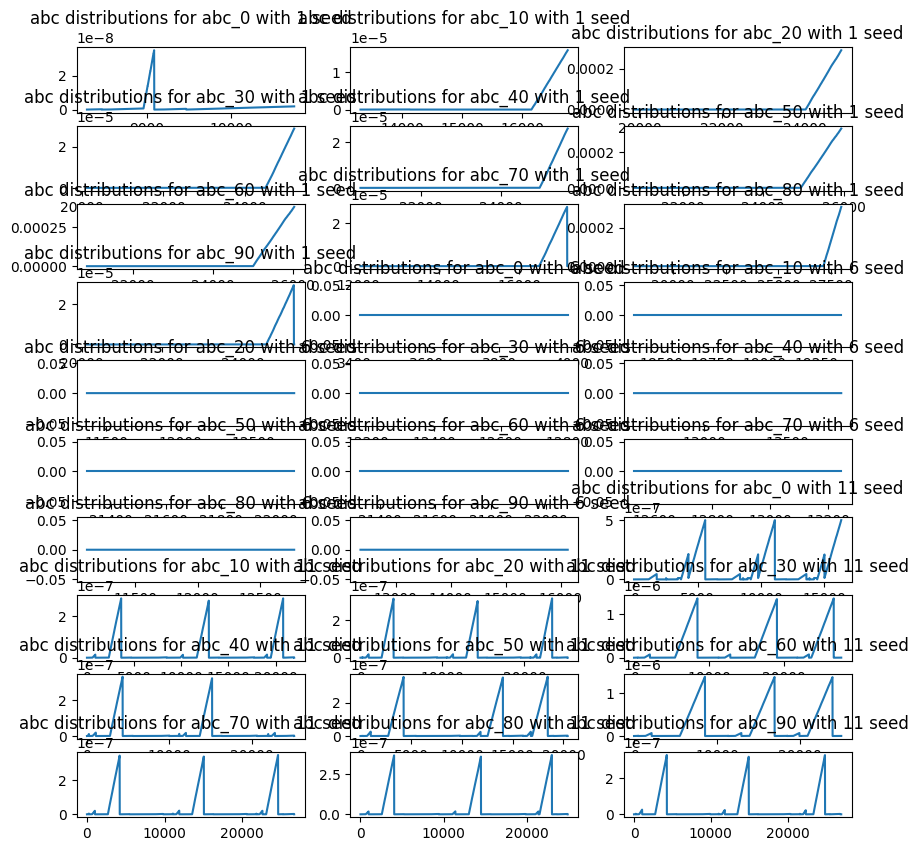

In [31]:
from itertools import product

# Assuming res_abc is your dictionary with data

# Get unique values for 'k' and 'perc'
unique_k_values = sorted(set(k for k, _ in res_abc.items()))
unique_perc_values = sorted(set(perc for _, v in res_abc.items() for perc in v.keys()))

# Set up the grid of plots (3 rows, 4 columns)
num_rows = 10
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate through the unique 'k' and 'perc' values
for i, (k_value, perc_value) in enumerate(product(unique_k_values, unique_perc_values)):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx, col_idx]
    
    # Extract data for the current 'k' and 'perc' values
    x_distr = list(res_abc[k_value][perc_value].keys())
    y_distr = list(res_abc[k_value][perc_value].values())
    
    # Plot on the current subplot
    ax.plot(x_distr, y_distr)
    ax.set_title(f"abc distributions for {perc_value} with {k_value} seed")

# Remove any excess empty subplots"
for i in range(len(unique_k_values) * len(unique_perc_values), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [24]:
#one with the highest frequency after deleting burnin period is the best
for k, v in data.items():
    for perc, r in v.items():
        list_values = list(res_abc[k][perc].values())
        mean = np.mean(list_values)
        median = np.median(list_values)
        frequency = dict(collections.Counter([round(v) for v in list_values]))
        mode = max(frequency, key=frequency.get)

        idx = [k for k, v in data[k][perc]["Results"]["graph_structure"].items() if round(v) == mode]
        dist = data[k][perc]["Results"]["Distance"][idx[0]]

        data[k][perc]["stats_abc_distr"] = {"mean": mean, "median": median, "frequency": frequency,
                                           "optimal_mode": mode, "Distance": dist}

In [25]:
gt_graph = ground_truth_topology["graph"][0]

for seed, attr in data.items():
    for perc, res in attr.items():
        #abc optimal
        sol_idx = int(data[seed][perc]["Optimal_solution"]["graph_structure"][0])
        sol_obj_value = data[seed][perc]["Optimal_solution"]["Distance"][0]
        
        sol_topology = decision_variables[round(sol_idx)]
        sol_graph = sol_topology["graph"]
        
        # combine ground truth and solutions
        column_names = ["edges", "nodes", "betweenness", "degree_centrality", "closeness_centrality"]
        df_sol_topology = pd.DataFrame.from_dict(sol_topology, orient="index").T[column_names].rename(index={0: 'solution'})
        df_gt_topology = ground_truth_topology[column_names].rename(index={0: 'ground_truth'})
        
        df_combined = pd.concat([df_gt_topology, df_sol_topology])
        
        # calculate differences
        
        diff_values = df_combined.loc['ground_truth'] - df_combined.loc['solution']
        df_diff = pd.DataFrame([diff_values], index=['diff'])
        
        df_combined_diff = pd.concat([df_combined, df_diff])
        
        # calculate graph edit distance
        ged=gm.GraphEditDistance(1,1,1,1) # all edit costs are equal to 1
        result=ged.compare([gt_graph, sol_graph],None) 
        
        distance = ged.distance(result)[1][0]
        
        # add to dictionary data
        data[seed][perc]["Quality_of_Fit"] = {"features": df_combined_diff, "graph_edit_distance": distance, "abs_dist": np.sum(result)}

        #abc frequency
        sol_idx = int(data[seed][perc]["stats_abc_distr"]["optimal_mode"])
        sol_obj_value = data[seed][perc]["stats_abc_distr"]["Distance"]
        
        sol_topology = decision_variables[round(sol_idx)]
        sol_graph = sol_topology["graph"]
        
        # combine ground truth and solutions
        column_names = ["edges", "nodes", "betweenness", "degree_centrality", "closeness_centrality"]
        df_sol_topology = pd.DataFrame.from_dict(sol_topology, orient="index").T[column_names].rename(index={0: 'solution'})
        df_gt_topology = ground_truth_topology[column_names].rename(index={0: 'ground_truth'})
        
        df_combined = pd.concat([df_gt_topology, df_sol_topology])
        
        # calculate differences
        
        diff_values = df_combined.loc['ground_truth'] - df_combined.loc['solution']
        df_diff = pd.DataFrame([diff_values], index=['diff'])
        
        df_combined_diff = pd.concat([df_combined, df_diff])
        
        # calculate graph edit distance
        ged=gm.GraphEditDistance(1,1,1,1) # all edit costs are equal to 1
        result=ged.compare([gt_graph, sol_graph],None) 
        
        distance = ged.distance(result)[1][0]
        
        # add to dictionary data
        data[seed][perc]["Quality_of_Fit_Frequency"] = {"features": df_combined_diff, "graph_edit_distance": distance, 
                                                        "stats": data[seed][perc]["stats_abc_distr"], "abs_dist": np.sum(result)}

In [26]:
file_name = directory + f"/final_{technique}_{sparseness}_all_seeds.pkl"
with open(file_name, "wb") as output:
    pickle.dump(data, output)